## 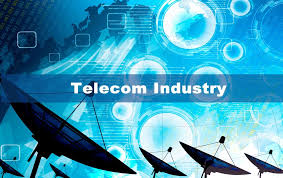

# INSAID Data Analytics Capstone Project
### - Group 1037                         

### Table of Contents
- 1. [Data Loading](#section1)</br>
- 2. [Data Preprocessing](#section2)</br>
- 3. [Exploratory Data Analysis](#section3)</br>
     - 3.1 [Distribution of Users(device_id) across States](#section301)<br/>
     - 3.2 [Distribution of Users across Top-10 Phone Brands](#section302)<br/>
     - 3.3 [Distribution of Users across Gender](#section303)<br/>
     - 3.4 [Distribution of Users across Age Segments](#section304)<br/>
     - 3.5 [Distribution of Top-10 Phone Brands for each Age Segment, State, Gender](#section305)<br/>
     - 3.6 [Distribuiion of Gender for each State, Age Segment and Top-10 Phone Brand](#section306)<br/>
     - 3.7 [Distribution of Age Segments for each State, Gender and Top-10 Phone Brand](#section307)<br/>
     - 3.8 [Hourly distribution of Phone Calls](#section308)<br/>
     - 3.9 [User Map Plot](#section309)<br/>
- 4. [Data Analytics Dashboard File Creation](#section4)</br>

<a id=section1> </a>
## 1. Data Loading

In [1]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import numpy as np
from pandas.io import sql
import pandas_profiling    

#import folium as fo

#from geopy.geocoders import Nominatim
import time

%matplotlib inline

import seaborn as sns

#import plotly.express as px

import matplotlib.pyplot as plt

sns.set(style='darkgrid')

C:\Users\DEVENDER\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    connection = mysql.connector.connect(host= 'cpanel.insaid.co',
                                     database='Capstone1',
                                     user='student',
                                     password='student'
                                     ) 
    if connection.is_connected():
       db_Info = connection.get_server_info()
       print("Connected to MySQL database... MySQL Server version on ",db_Info)
    
except Error as e :
    print ("Error while connecting to MySQL", e)


Connected to MySQL database... MySQL Server version on  5.6.49-cll-lve


In [3]:
cursor = connection.cursor()
query = "SELECT * FROM gender_age_train"

cursor.execute(query)
rows = cursor.fetchall()

gatDf = pd.DataFrame(data=rows,columns=['device_id','gender','age','group'])

In [4]:
gatDf.to_csv('gender_age_train.csv',index=False)

<a id=section2></a>
## 2. Data Preprocessing

In [5]:
gatDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device_id  74645 non-null  int64 
 1   gender     74645 non-null  object
 2   age        74645 non-null  int64 
 3   group      74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [6]:
gatDf.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [7]:
gatDf.group.unique()

array(['M32-38', 'M29-31', 'F24-26', 'F33-42', 'F27-28', 'M39+', 'M23-26',
       'M27-28', 'M22-', 'F43+', 'F23-', 'F29-32'], dtype=object)

In [8]:
import pandas_profiling                                                      # Get a quick overview for all the variables using pandas_profiling                                         
profile = pandas_profiling.ProfileReport(gatDf)
profile.to_file("gatDfpreprofile.html")

ValueError: Number of samples, -383142, must be non-negative.

In [11]:
cursor = connection.cursor()
query = "SELECT * FROM phone_brand_device_model"

cursor.execute(query)
rows = cursor.fetchall()

bdmDf = pd.DataFrame(data=rows,columns=['device_id','phone_brand','device_model'])

InterfaceError: 2013: Lost connection to MySQL server during query

In [ ]:
bdmDf.to_csv('phone_br_dev_model.csv',index=False)

In [ ]:
bdmDf.info()

In [ ]:
profile = pandas_profiling.ProfileReport(bdmDf)
profile.to_file("bdmDfpreprofile.html")

In [ ]:
evdataDf = pd.read_csv('events_data.csv')

In [ ]:
evdataDf.head()

In [ ]:
evdataDf.info()

In [ ]:
gatDf.isnull().sum()

In [ ]:
bdmDf.isnull().sum()

In [ ]:
evdataDf.isnull().sum()

In [ ]:
evdataDf[evdataDf.state.isnull() & evdataDf.longitude.isnull() & evdataDf.latitude.isnull()]


There are no rows where all state, logitude and latitude are null so we can derive state from 
longitude and lattitude during pre-processing

In [ ]:
gatDf.info()

In [ ]:
evdataDf.info()

In [ ]:
def updateState(Df):
    if(pd.isnull(Df.state)):
        lat = Df['latitude']
        long = Df['longitude']
        coordinates=(str(lat) + ',' +str(long))
        geolocator = Nominatim(user_agent="Testing")
        location = geolocator.reverse(coordinates)
        address = location.address.split(',')
        
        if(len(address) == 4):
            state = address[-2]
            state = state.lstrip()
        else:
             state = address[-3]
             state = state.lstrip()
        
        print(state)
        return state
    else:
        return Df.state

In [ ]:
def DataPreprocessing():
    ##Drop rows with missing 'device_id', 'longitude','lattitude'
    evdataDf.dropna(subset=['device_id','longitude','latitude'],inplace=True)
    ## Convert the device_id format from exponential to int
    evdataDf['device_id'] = evdataDf['device_id'].astype('int64') 
    ## Try to get the state value from longitude & latitude if the same are present for rows where state vlaues are null
    evdataDf.state = evdataDf.apply(updateState,axis=1)       

In [ ]:
DataPreprocessing()

In [ ]:
from folium.plugins import FastMarkerCluster


# Check if lat long values are correct by plotting on Folium
# define centre of map

# take unique lat and long
mapdf = evdataDf.groupby(['longitude','latitude'],as_index=False)['device_id'].count()
locations = mapdf[['longitude','latitude']]

locationlist = locations.values.tolist()

center = (mapdf['latitude'].mean(), mapdf['longitude'].mean())
map = fo.Map(location=center, zoom_start=12)


FastMarkerCluster(data=locationlist).add_to(map)
fo.LayerControl().add_to(map)

for index, row in mapdf.iterrows():
    
    fo.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius=5,
                        color='maroon',
                        fill=False).add_to(map)
    
map

In [ ]:
mapdf.describe()

#### The map cleary shows that there are some lat and long not within India. These lat and long values are wrong.

<a id=section3></a>
## 3. Exploratory Data Analysis

#### Pre-processing is complete. Let's do remaining pre-processing if any and perform EDA on the Data.

#### Let's Merge All the dataframes to create a single data-frame, before merging convert the device_id to float to solve the merge issue.

In [ ]:
# Convert Chinese brands to English before doing EDA for this
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '华为','Huawei',bdmDf['phone_brand'])
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '小米','Xiaomi',bdmDf['phone_brand'])
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '三星','Samsung',bdmDf['phone_brand'])
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '魅族','Meizu',bdmDf['phone_brand'])
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '酷派','Coolpad',bdmDf['phone_brand'])
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '乐视','LeEco',bdmDf['phone_brand'])
bdmDf['phone_brand'] = np.where(bdmDf['phone_brand'] == '联想 ','Lenovo',bdmDf['phone_brand'])

In [ ]:
evdataDf['device_id'] = evdataDf['device_id'].astype('float') 

In [ ]:
gatDf['device_id'] = gatDf['device_id'].astype('float')

In [ ]:
bdmDf['device_id'] = bdmDf['device_id'].astype('float')

##### Merge the Dataframes into single dataframe for carrying out the analysis

In [ ]:
gatBDMDf = pd.merge(gatDf,bdmDf,how='inner')

In [ ]:
mrgdDf = pd.merge(gatBDMDf,evdataDf,how='inner')

##### Current age groups are not uniform across gender. let's create uniform age group across gender

In [ ]:
mrgdDf['ageGroup'] = pd.cut(mrgdDf['age'],[0,18,36,56,96], 
                                labels = ['<18','18-35','36-55','>55'], include_lowest = True)
mrgdDf['ageGroup'] = mrgdDf['ageGroup'].astype(object)

In [ ]:
mrgdDf.info()

<a id=section301></a>
### 3.1 Distribution of Users(device_id) across States

##### Considering that there are multiple events for same device id create another dataframe by dropping duplicates and retaining first record so as to do user related analysis

In [ ]:
analysisDf = mrgdDf.drop_duplicates(subset=['device_id'])

In [ ]:
analysisDf.info()

In [ ]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

order = analysisDf['state'].value_counts(ascending=False).index

sns.countplot(y='state',data=stateWiseDf,ax=ax,order=order)

<a id=section302></a>
### 3.2 Distribution of Users across Top-10 Phone Brands

##### Merge the dataframes to get the desired data

In [ ]:
top10brands = analysisDf['phone_brand'].value_counts()[:10]
ax = top10brands.plot.bar(color='magenta',fontsize=12)
ax.set_title('Top 10 Phone Brands', fontsize=15)
ax.set_ylabel('Number of Brand Users')

In [ ]:
top10brands

<a id=section303></a>
### 3.3 Distribution of Users across Gender

In [ ]:
analysisDf.gender.value_counts()

In [ ]:
gendercounts = analysisDf.gender.value_counts()
ax = gendercounts.plot.pie(autopct='%1.1f%%',shadow=True,fontsize=15)
circle = plt.Circle(xy=(0, 0), radius=0.5, facecolor='white')
plt.gca().add_artist(circle)

ax.set_title("User Gender Distribution")

plt.show()

<a id=section304></a>
### 3.4 Distribution of Users across Age Segments

In [ ]:
fig, ax = plt.subplots(figsize=(22,10))
analysisDf.ageGroup.value_counts().plot.pie(explode=(0.1,0,0,0),autopct='%1.1f%%',\
                                          ax=ax,shadow=True,textprops={'fontsize': 14})

ax.set_title('User Age Group Distribution',fontsize = 18)

ax.axis('equal')

<a id=section305></a>
### 3.5 Distribution of Top-10 Phone Brands for each Age Segment, State, Gender

In [ ]:
#Create Dataframe with Top-10 brands
top10brandDf =  analysisDf[analysisDf.phone_brand.isin(['Xiaomi','Samsung','Huawei','vivo','OPPO','Meizu','Coolpad','HTC','Lenovo','LeEco'])]

In [ ]:
top10brandDf.info()

In [ ]:
ax = top10brandDf.groupby(['ageGroup', 'phone_brand']).size().unstack()\
.plot(kind='barh',stacked=True,figsize=(15,8),fontsize=15)
ax.set_title('Age Group Vs Brand',fontsize=20)
ax.set_ylabel('Age Group',size=15)

In [ ]:
ax = top10brandDf.groupby(['state', 'phone_brand']).size().unstack()\
.plot(kind='bar',stacked=True,figsize=(15,8),fontsize=15)
ax.set_title('State Vs Brand',fontsize=20)
ax.set_xlabel('State',size=15)

In [ ]:
ax = top10brandDf.groupby(['gender', 'phone_brand']).size().unstack()\
.plot(kind='barh',stacked=True,figsize=(15,4),fontsize=15)
ax.set_title('Gender Vs Brand',fontsize=20)
ax.set_ylabel('Gender',size=15)

<a id=section306></a>
### 3.6 Distribuiion of Gender for each State, Age Segment and Top-10 Phone Brand

Use analysisDf here as we need to do gender analysis for state

In [ ]:
ax = analysisDf.groupby(['state', 'gender']).size().unstack()\
.plot(kind='barh',stacked=True,figsize=(15,15),fontsize=15)
ax.set_title('State Vs Gender',fontsize=12)
ax.set_ylabel('State',size=15)

In [ ]:
ax = analysisDf.groupby(['ageGroup', 'gender']).size().unstack()\
.plot(kind='bar',stacked=True,figsize=(8,6),fontsize=15)
ax.set_title('Age Segment Vs Gender',fontsize=12)
ax.set_xlabel('Age Segment',size=15)

In [ ]:
ax = top10brandDf.groupby(['phone_brand', 'gender']).size().unstack()\
.plot(kind='bar',stacked=True,figsize=(8,6),fontsize=15)
ax.set_title('Phone Brand Vs Gender',fontsize=12)
ax.set_xlabel('Phone Brand',size=15)

<a id=section307></a>
### 3.7 Distribution of Age Segments for each State, Gender and Top-10 Phone Brand

In [ ]:
ax = analysisDf.groupby(['state', 'ageGroup']).size().unstack()\
.plot(kind='barh',stacked=True,figsize=(10,10),fontsize=15)
ax.set_title('State Vs Age Segment',fontsize=12)
ax.set_ylabel('State',size=15)

In [ ]:
ax = analysisDf.groupby(['gender', 'ageGroup']).size().unstack()\
.plot(kind='barh',stacked=True,figsize=(10,5),fontsize=15)
ax.set_title('Gender Vs Age Segment',fontsize=12)
ax.set_ylabel('Gender',size=15)

In [ ]:
ax = top10brandDf.groupby(['phone_brand', 'ageGroup']).size().unstack()\
.plot(kind='barh',stacked=True,figsize=(10,10),fontsize=15)
ax.set_title('Phone Brand Vs Age Segment',fontsize=12)
ax.set_ylabel('Phone Brand',size=15)

<a id=section308></a>
### 3.8 Hourly distribution of Phone Calls

In [ ]:
# For hourly distribution of phone calls let's use a different dataframe with device_id and timestamp
timedistDf = mrgdDf[['device_id','timestamp']]
timedistDf["timestamp"] = pd.to_datetime(timedistDf["timestamp"])
timedistDf['hour'] = timedistDf['timestamp'].dt.hour

In [ ]:
timedistDf.drop(['timestamp'],axis=1,inplace=True)

In [ ]:
hrgrp = timedistDf.groupby('hour').count()

In [ ]:
hrgrp.plot()

<a id=section309></a>
### 3.9 User Map Plot

In [ ]:
# Check if lat long values are correct by plotting on Folium
# define centre of map

# take unique lat and long
locations = analysisDf[['longitude','latitude']]

locationlist = locations.values.tolist()

center = (analysisDf['latitude'].mean(), analysisDf['longitude'].mean())
map = fo.Map(location=center, zoom_start=5)

FastMarkerCluster(data=locationlist).add_to(map)
fo.LayerControl().add_to(map)

for index, row in analysisDf.iterrows():
    
    fo.CircleMarker(location=(row["latitude"],
                                  row["longitude"]),
                        radius=0.1,
                        color='maroon',
                        fill=False).add_to(map)
    
map

<a id=section4></a>
## 4. Data Analytics Dashboard File Creation

In [ ]:
mrgdDf.info()

In [ ]:
# Use the merged dataframe to create output file selecting only Maharashtra state data
outDf = mrgdDf[mrgdDf['state'] == 'Maharashtra'][['event_id','device_id','timestamp','longitude','latitude','state']] 

outDf['event_id'] = outDf['event_id'].astype('int64') # Convert into required format
outDf['device_id'] = outDf['device_id'].astype('int64')# Convert into required format

#Write to output csv file
outDf.to_csv()


In [ ]:
outDf.to_csv('1037_Mahrashra_Analytics.csv',index=False)

In [ ]:
if (connection.is_connected()):
    connection.close()
    cursor.close()
    print("MySQL connection is closed")